In [2]:
%load_ext autoreload
%autoreload 2

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

In [58]:
df = pd.read_csv('data/game/box_raw/reshaped_regular_season_games.csv')
df = df[df['SEASON'] != '2019-20']

In [73]:
new_df = df.copy()

In [79]:
for year in new_df['SEASON'].unique():
    year_df = new_df[new_df['SEASON'] == year]
    for stat in ['PTS', 'PACE', 'FGM', 'FGA', '3PT_FGM', '3PT_FGA', 'FTM', 'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', '3PAR', 'FTR', 'ORTG', 'DRTG', '2PT_FGM', '2PT_FGA']:
        # For each stat, fit a line to see if game number predicts the stat value
        X = year_df['GAME_NUMBER'].values.reshape(-1, 1)
        y = year_df[stat].values
        
        # fit linear regression
        m = ((X.ravel() * y).mean() - X.mean() * y.mean()) / ((X.ravel()**2).mean() - X.mean()**2)
        print(f'correlation of GAME_NUMBER and {stat} in {year}: {m}')
        
        # Adjust the stat by subtracting the line to remove correlation with game number
        adjusted = y - (m * X.ravel())
        
        # Store back in dataframe 
        new_df.loc[(df['SEASON'] == year), stat] = adjusted



correlation of GAME_NUMBER and PTS in 2000-01: -2.334353768677438e-07
correlation of GAME_NUMBER and PACE in 2000-01: 3.381435302963991e-07
correlation of GAME_NUMBER and FGM in 2000-01: 1.0497085997894646e-06
correlation of GAME_NUMBER and FGA in 2000-01: 1.6043990929370509e-06
correlation of GAME_NUMBER and 3PT_FGM in 2000-01: 3.4910223080602975e-06
correlation of GAME_NUMBER and 3PT_FGA in 2000-01: 4.736261181651648e-07
correlation of GAME_NUMBER and FTM in 2000-01: 1.7511406245657696e-06
correlation of GAME_NUMBER and FTA in 2000-01: -6.755364604189833e-07
correlation of GAME_NUMBER and ORB in 2000-01: 2.10166898711339e-07
correlation of GAME_NUMBER and DRB in 2000-01: 4.2971624825619386e-07
correlation of GAME_NUMBER and TRB in 2000-01: -7.843728939026934e-08
correlation of GAME_NUMBER and AST in 2000-01: 3.253833953202892e-07
correlation of GAME_NUMBER and STL in 2000-01: -7.517219612601836e-07
correlation of GAME_NUMBER and BLK in 2000-01: -1.6813351909082418e-07
correlation of 

Correlation between game number and points after adjustment: 0.0003


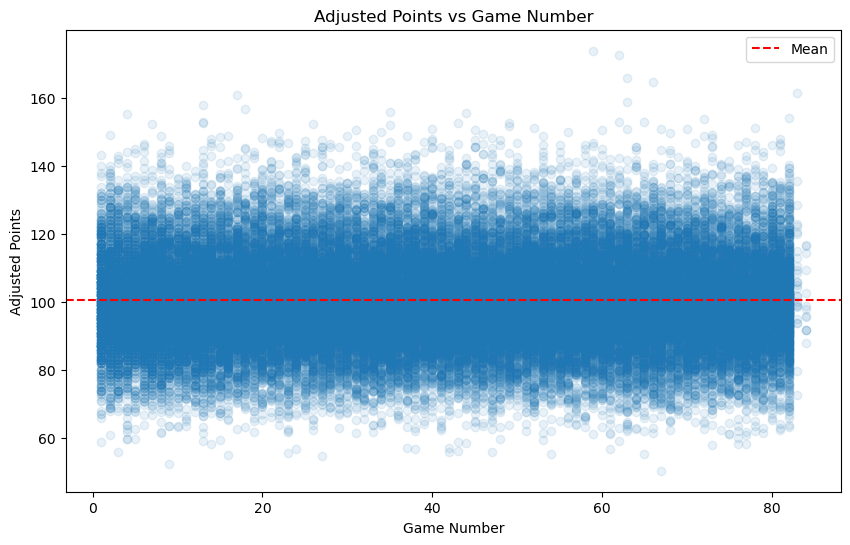

In [78]:
# Calculate correlation between GAME_NUMBER and PTS after adjustments
correlation = new_df['GAME_NUMBER'].corr(new_df['PTS'])
print(f"Correlation between game number and points after adjustment: {correlation:.4f}")

# This should be very close to 0 since we removed the linear trend
# Let's verify visually
plt.figure(figsize=(10,6))
plt.scatter(new_df['GAME_NUMBER'], new_df['PTS'], alpha=0.1)
plt.axhline(y=new_df['PTS'].mean(), color='r', linestyle='--', label='Mean')
plt.xlabel('Game Number')
plt.ylabel('Adjusted Points')
plt.title('Adjusted Points vs Game Number')
plt.legend()
plt.show()
